In [ ]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset
from torch import nn
import torch
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Часть 1: Подготовка данных

In [ ]:

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Часть 2: Базовая архитектура ResNet18

## 2.1. Реализация Basic Block

In [ ]:

class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        if self.downsample is None and (in_channels != out_channels or stride != 1):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        if (self.downsample is not None):
            identity = self.downsample(x)
        else:
            identity = x
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        out = self.relu(x + identity)

        return out

## 2.2. Реализация ResNet18

In [ ]:
class ResNet18ImageNetTiny(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.basic_block_11 = BasicBlock(64, 64)
        self.basic_block_12 = BasicBlock(64, 64)

        self.basic_block_21 = BasicBlock(64, 128, stride=2)
        self.basic_block_22 = BasicBlock(128, 128)

        self.basic_block_31 = BasicBlock(128, 256, stride=2)
        self.basic_block_32 = BasicBlock(256, 256)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.basic_block_12(self.basic_block_11(x))
        x = self.basic_block_22(self.basic_block_21(x))
        x = self.basic_block_32(self.basic_block_31(x))

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x

model = ResNet18ImageNetTiny(num_classes=10)
test_input = torch.randn(1, 3, 64, 64)

output = model(test_input)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")

 Всего параметров: 2,778,058
 Обучаемых параметров: 2,778,058


## 2.3. Скрипт обучения

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одной эпохи обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпоху
        train_acc: средняя точность за эпоху
    """
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm.tqdm(train_loader, desc="Training")
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)

        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        pbar.set_postfix({
            'loss': f'{running_loss / total:.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })
    
    return running_loss / total, correct / total

In [45]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm.tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = output.max(1)

            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            pbar.set_postfix({
                'loss': f'{running_loss / total:.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
            
    
    return running_loss / total, correct / total

In [ ]:

def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    """
    Основная функция для обучения модели
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох
    
    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {100*val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/home/victor/Desktop/itmo/dz_2/tiny-imagenet-200/best_model.pth')
            print(f"Сохранена лучшая модель с точностью {100*val_acc:.2f}%")
        print()
    return history, best_val_acc

def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_acc(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for h in history:
        ax1.plot(h[0]['train_acc'], label=h[1])

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    for h in history:
        ax2.plot(h[0]['val_acc'], label=h[1])

    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:

root = "/home/victor/Desktop/itmo/dz_2/tiny-imagenet-200/tiny-imagenet-200"

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")

Train size: 100000
Val size: 10000
Классов: 200


In [ ]:
# Для быстрого теста можно использовать только несколько классов
selected_classes = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36]
subset_train_samples = [s for s in train_dataset.samples if s[1] in selected_classes]
subset_val_samples = [s for s in val_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_train_samples)} train и {len(subset_val_samples)} val изображений "
      f"из {len(selected_classes)} классов")

# Перенумеровка классов
class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)


class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_subset_dataset = CustomDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = CustomDataset(subset_val_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)

Используем 5000 train и 500 val изображений из 10 классов


device: cuda
Обучение на 20 эпох...
Эпоха 1/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.33it/s, loss=0.0292, acc=35.00%]


 Train Loss: 0.0317, Train Acc: 27.28%
 Val Loss: 0.0292, Val Acc: 35.00%
Сохранена лучшая модель с точностью 35.00%

Эпоха 2/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.00it/s, loss=0.0321, acc=33.80%]


 Train Loss: 0.0283, Train Acc: 36.58%
 Val Loss: 0.0321, Val Acc: 33.80%

Эпоха 3/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s, loss=0.0249, acc=46.80%]


 Train Loss: 0.0259, Train Acc: 41.90%
 Val Loss: 0.0249, Val Acc: 46.80%
Сохранена лучшая модель с точностью 46.80%

Эпоха 4/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.75it/s, loss=0.0233, acc=50.80%]


 Train Loss: 0.0243, Train Acc: 46.72%
 Val Loss: 0.0233, Val Acc: 50.80%
Сохранена лучшая модель с точностью 50.80%

Эпоха 5/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.67it/s, loss=0.0251, acc=42.60%]


 Train Loss: 0.0229, Train Acc: 50.64%
 Val Loss: 0.0251, Val Acc: 42.60%

Эпоха 6/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.59it/s, loss=0.0286, acc=43.60%]


 Train Loss: 0.0219, Train Acc: 51.88%
 Val Loss: 0.0286, Val Acc: 43.60%

Эпоха 7/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.93it/s, loss=0.0211, acc=55.80%]


 Train Loss: 0.0213, Train Acc: 53.66%
 Val Loss: 0.0211, Val Acc: 55.80%
Сохранена лучшая модель с точностью 55.80%

Эпоха 8/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.01it/s, loss=0.0205, acc=58.20%]


 Train Loss: 0.0197, Train Acc: 57.56%
 Val Loss: 0.0205, Val Acc: 58.20%
Сохранена лучшая модель с точностью 58.20%

Эпоха 9/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.97it/s, loss=0.0222, acc=57.00%]


 Train Loss: 0.0194, Train Acc: 58.50%
 Val Loss: 0.0222, Val Acc: 57.00%

Эпоха 10/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.24it/s, loss=0.0226, acc=53.00%]


 Train Loss: 0.0189, Train Acc: 59.04%
 Val Loss: 0.0226, Val Acc: 53.00%

Эпоха 11/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.24it/s, loss=0.0224, acc=57.60%]


 Train Loss: 0.0179, Train Acc: 61.84%
 Val Loss: 0.0224, Val Acc: 57.60%

Эпоха 12/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.53it/s, loss=0.0215, acc=58.00%]


 Train Loss: 0.0170, Train Acc: 63.94%
 Val Loss: 0.0215, Val Acc: 58.00%

Эпоха 13/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.81it/s, loss=0.0235, acc=57.60%]


 Train Loss: 0.0166, Train Acc: 64.46%
 Val Loss: 0.0235, Val Acc: 57.60%

Эпоха 14/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.01it/s, loss=0.0196, acc=61.20%]


 Train Loss: 0.0162, Train Acc: 65.54%
 Val Loss: 0.0196, Val Acc: 61.20%
Сохранена лучшая модель с точностью 61.20%

Эпоха 15/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.88it/s, loss=0.0178, acc=61.40%]


 Train Loss: 0.0160, Train Acc: 66.14%
 Val Loss: 0.0178, Val Acc: 61.40%
Сохранена лучшая модель с точностью 61.40%

Эпоха 16/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.98it/s, loss=0.0158, acc=66.60%]


 Train Loss: 0.0153, Train Acc: 67.16%
 Val Loss: 0.0158, Val Acc: 66.60%
Сохранена лучшая модель с точностью 66.60%

Эпоха 17/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.18it/s, loss=0.0192, acc=62.00%]


 Train Loss: 0.0144, Train Acc: 69.34%
 Val Loss: 0.0192, Val Acc: 62.00%

Эпоха 18/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.81it/s, loss=0.0175, acc=65.40%]


 Train Loss: 0.0145, Train Acc: 68.96%
 Val Loss: 0.0175, Val Acc: 65.40%

Эпоха 19/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.38it/s, loss=0.0156, acc=70.40%]


 Train Loss: 0.0143, Train Acc: 69.38%
 Val Loss: 0.0156, Val Acc: 70.40%
Сохранена лучшая модель с точностью 70.40%

Эпоха 20/20


Validation: 100%|██████████| 8/8 [00:01<00:00,  7.39it/s, loss=0.0178, acc=65.00%]


 Train Loss: 0.0138, Train Acc: 70.78%
 Val Loss: 0.0178, Val Acc: 65.00%



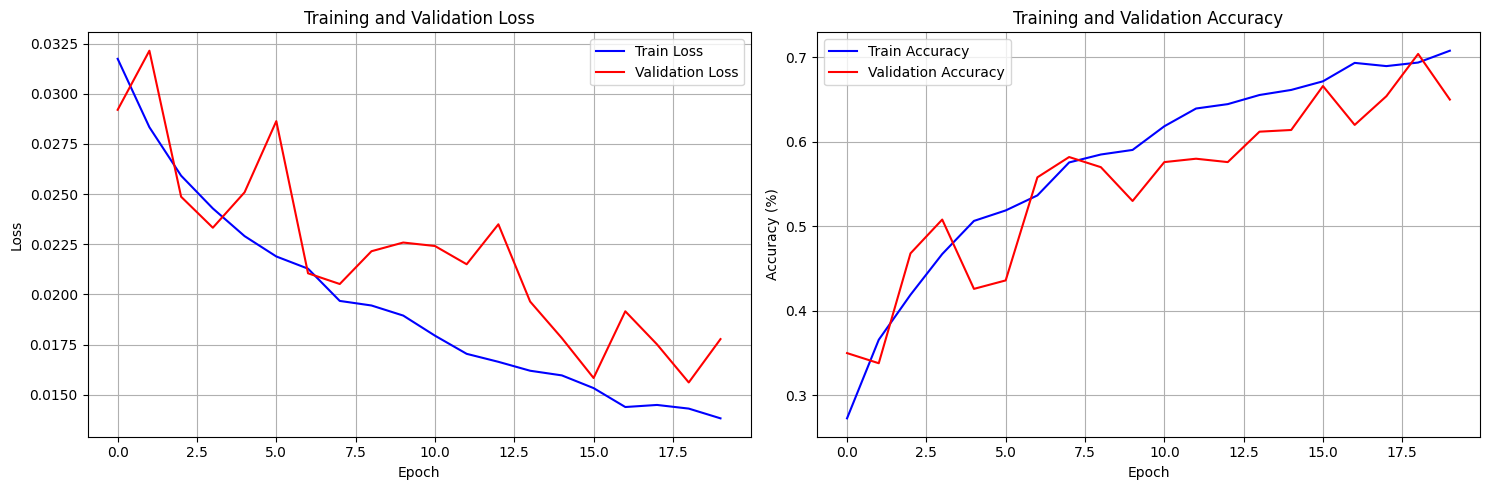

In [151]:
model = ResNet18ImageNetTiny(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
history, best_acc_val = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

plot_training_history(history)

In [39]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")

 Всего параметров: 2,778,058
 Обучаемых параметров: 2,778,058


In [40]:
print(model)

ResNet18ImageNetTiny(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (basic_block_11): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (basic_block_12): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (

# Часть 3: Поэтапная оптимизация модели

## 3.1 Оптимизация количества каналов

Модель варианта B ( 64 → 128 → 256 каналов (без 4-го слоя)) уже построена.
Обучаю модель варианта A: 32 → 64 → 128 → 256 каналов

In [ ]:
class ResNet18ImageNetTinyA(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.basic_block_11 = BasicBlock(32, 32, stride=2)
        self.basic_block_12 = BasicBlock(32, 32)

        self.basic_block_21 = BasicBlock(32, 64, stride=2)
        self.basic_block_22 = BasicBlock(64, 64)

        self.basic_block_31 = BasicBlock(64, 128, stride=2)
        self.basic_block_32 = BasicBlock(128, 128)

        self.basic_block_41 = BasicBlock(128, 256, stride=2)
        self.basic_block_42 = BasicBlock(256, 256)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.basic_block_12(self.basic_block_11(x))
        x = self.basic_block_22(self.basic_block_21(x))
        x = self.basic_block_32(self.basic_block_31(x))
        x = self.basic_block_42(self.basic_block_41(x))

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x

In [68]:
modelA = ResNet18ImageNetTinyA(num_classes=len(selected_classes))

optimizer = torch.optim.Adam(modelA.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
historyA, best_acc_val_A = train_model(
    model=modelA,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

device: cuda
Обучение на 20 эпох...
Эпоха 1/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.89it/s, loss=0.0341, acc=29.00%]


 Train Loss: 0.0314, Train Acc: 28.82%
 Val Loss: 0.0341, Val Acc: 29.00%
Сохранена лучшая модель с точностью 29.00%

Эпоха 2/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.45it/s, loss=0.0248, acc=42.80%]


 Train Loss: 0.0278, Train Acc: 38.08%
 Val Loss: 0.0248, Val Acc: 42.80%
Сохранена лучшая модель с точностью 42.80%

Эпоха 3/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.38it/s, loss=0.0231, acc=47.60%]


 Train Loss: 0.0252, Train Acc: 43.46%
 Val Loss: 0.0231, Val Acc: 47.60%
Сохранена лучшая модель с точностью 47.60%

Эпоха 4/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.0230, acc=50.20%]


 Train Loss: 0.0232, Train Acc: 47.76%
 Val Loss: 0.0230, Val Acc: 50.20%
Сохранена лучшая модель с точностью 50.20%

Эпоха 5/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.28it/s, loss=0.0222, acc=54.80%]


 Train Loss: 0.0217, Train Acc: 52.08%
 Val Loss: 0.0222, Val Acc: 54.80%
Сохранена лучшая модель с точностью 54.80%

Эпоха 6/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.83it/s, loss=0.0199, acc=57.40%]


 Train Loss: 0.0203, Train Acc: 55.02%
 Val Loss: 0.0199, Val Acc: 57.40%
Сохранена лучшая модель с точностью 57.40%

Эпоха 7/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.67it/s, loss=0.0208, acc=55.60%]


 Train Loss: 0.0194, Train Acc: 57.92%
 Val Loss: 0.0208, Val Acc: 55.60%

Эпоха 8/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.0177, acc=63.80%]


 Train Loss: 0.0184, Train Acc: 60.18%
 Val Loss: 0.0177, Val Acc: 63.80%
Сохранена лучшая модель с точностью 63.80%

Эпоха 9/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.37it/s, loss=0.0184, acc=60.80%]


 Train Loss: 0.0177, Train Acc: 61.84%
 Val Loss: 0.0184, Val Acc: 60.80%

Эпоха 10/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.73it/s, loss=0.0172, acc=65.60%]


 Train Loss: 0.0175, Train Acc: 62.10%
 Val Loss: 0.0172, Val Acc: 65.60%
Сохранена лучшая модель с точностью 65.60%

Эпоха 11/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.12it/s, loss=0.0154, acc=68.00%]


 Train Loss: 0.0164, Train Acc: 65.40%
 Val Loss: 0.0154, Val Acc: 68.00%
Сохранена лучшая модель с точностью 68.00%

Эпоха 12/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.12it/s, loss=0.0169, acc=66.00%]


 Train Loss: 0.0155, Train Acc: 67.30%
 Val Loss: 0.0169, Val Acc: 66.00%

Эпоха 13/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.43it/s, loss=0.0185, acc=63.40%]


 Train Loss: 0.0151, Train Acc: 67.50%
 Val Loss: 0.0185, Val Acc: 63.40%

Эпоха 14/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.14it/s, loss=0.0156, acc=67.80%]


 Train Loss: 0.0142, Train Acc: 69.44%
 Val Loss: 0.0156, Val Acc: 67.80%

Эпоха 15/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.18it/s, loss=0.0174, acc=67.20%]


 Train Loss: 0.0136, Train Acc: 70.50%
 Val Loss: 0.0174, Val Acc: 67.20%

Эпоха 16/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.19it/s, loss=0.0153, acc=68.60%]


 Train Loss: 0.0129, Train Acc: 72.86%
 Val Loss: 0.0153, Val Acc: 68.60%
Сохранена лучшая модель с точностью 68.60%

Эпоха 17/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.77it/s, loss=0.0159, acc=66.60%]


 Train Loss: 0.0131, Train Acc: 72.20%
 Val Loss: 0.0159, Val Acc: 66.60%

Эпоха 18/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.03it/s, loss=0.0164, acc=69.60%]


 Train Loss: 0.0124, Train Acc: 73.64%
 Val Loss: 0.0164, Val Acc: 69.60%
Сохранена лучшая модель с точностью 69.60%

Эпоха 19/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.42it/s, loss=0.0155, acc=69.80%]


 Train Loss: 0.0116, Train Acc: 76.06%
 Val Loss: 0.0155, Val Acc: 69.80%
Сохранена лучшая модель с точностью 69.80%

Эпоха 20/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.61it/s, loss=0.0167, acc=68.20%]

 Train Loss: 0.0110, Train Acc: 76.72%
 Val Loss: 0.0167, Val Acc: 68.20%



Вариант A

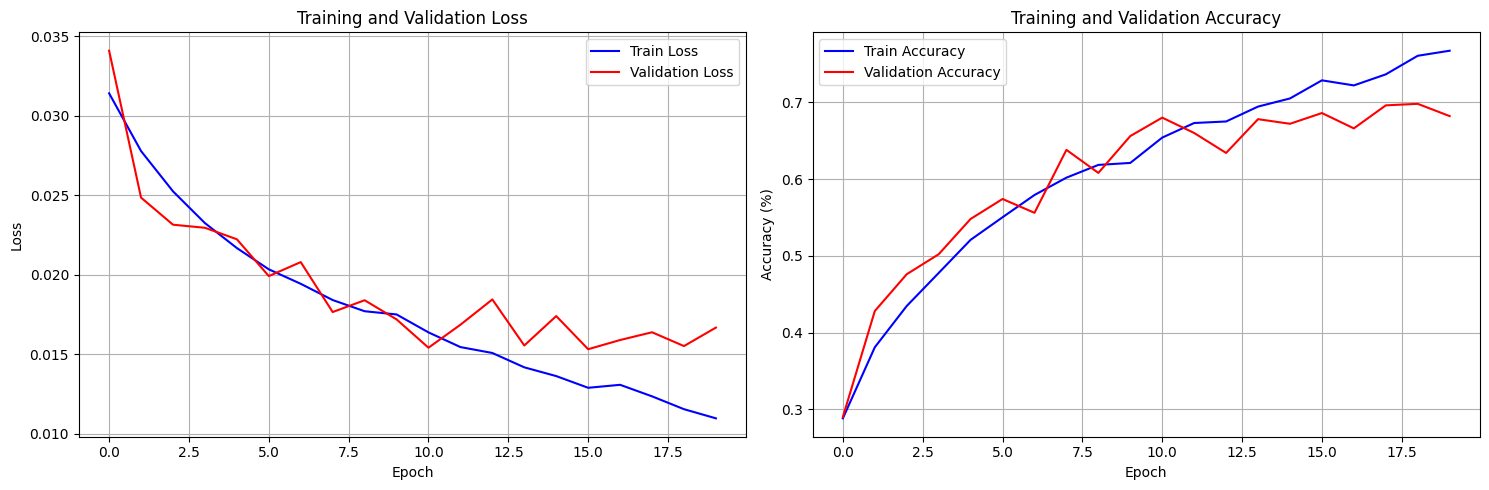

In [71]:
plot_training_history(historyA)

Вариант B

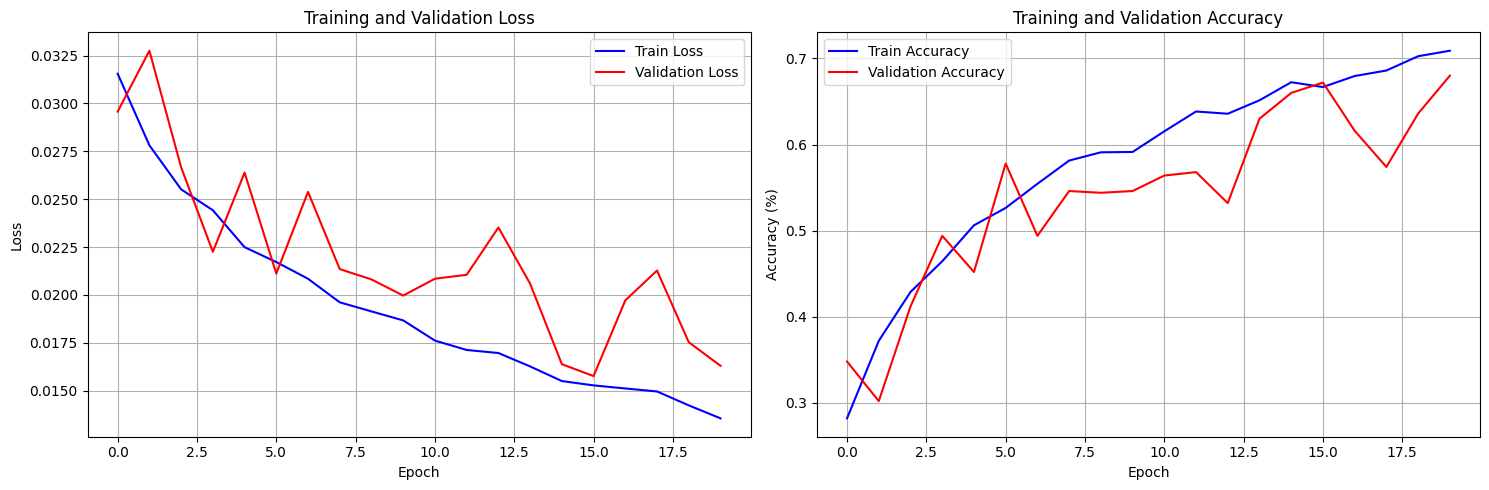

In [72]:
plot_training_history(history)

In [75]:
total_params = sum(p.numel() for p in modelA.parameters())
trainable_params_A = sum(p.numel() for p in modelA.parameters() if p.requires_grad)
print(f" Всего параметров варианта А: {total_params:,}")
print(f" Обучаемых параметров варианта А: {trainable_params_A:,}")

 Всего параметров варианта А: 2,799,178
 Обучаемых параметров варианта А: 2,799,178


In [76]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params_B = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров варианта B: {total_params:,}")
print(f" Обучаемых параметров варианта B: {trainable_params_B:,}")

 Всего параметров варианта B: 2,778,058
 Обучаемых параметров варианта B: 2,778,058


In [ ]:
import pandas as pd

results = [
    {"Модель": "ResNet18-A", "Количество параметров": trainable_params_A, "Лучшая точность валидации": best_acc_val_A},
    {"Модель": "ResNet18-B", "Количество параметров": trainable_params_B, "Лучшая точность валидации": best_acc_val},
]

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

| Модель     |   Количество параметров |   Лучшая точность валидации |
|:-----------|------------------------:|----------------------------:|
| ResNet18-A |                 2799178 |                       0.698 |
| ResNet18-B |                 2778058 |                       0.68  |


У варианта A точность немного выше, берём её

## 3.2 Эксперименты с количеством residual блоков

In [78]:
class ResNet18ImageNetTinySmall(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.basic_block_11 = BasicBlock(32, 32, stride=2)

        self.basic_block_21 = BasicBlock(32, 64, stride=2)

        self.basic_block_31 = BasicBlock(64, 128, stride=2)

        self.basic_block_41 = BasicBlock(128, 256, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.basic_block_11(x)
        x = self.basic_block_21(x)
        x = self.basic_block_31(x)
        x = self.basic_block_41(x)

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x
    
class ResNet18ImageNetTinyNormal(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.basic_block_11 = BasicBlock(32, 32, stride=2)
        self.basic_block_12 = BasicBlock(32, 32)

        self.basic_block_21 = BasicBlock(32, 64, stride=2)
        self.basic_block_22 = BasicBlock(64, 64)

        self.basic_block_31 = BasicBlock(64, 128, stride=2)
        self.basic_block_32 = BasicBlock(128, 128)

        self.basic_block_41 = BasicBlock(128, 256, stride=2)
        self.basic_block_42 = BasicBlock(256, 256)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.basic_block_12(self.basic_block_11(x))
        x = self.basic_block_22(self.basic_block_21(x))
        x = self.basic_block_32(self.basic_block_31(x))
        x = self.basic_block_42(self.basic_block_41(x))

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x

class ResNet18ImageNetTinyLarge(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.basic_block_11 = BasicBlock(32, 32, stride=2)
        self.basic_block_12 = BasicBlock(32, 32)
        self.basic_block_13 = BasicBlock(32, 32)

        self.basic_block_21 = BasicBlock(32, 64, stride=2)
        self.basic_block_22 = BasicBlock(64, 64)
        self.basic_block_23 = BasicBlock(64, 64)

        self.basic_block_31 = BasicBlock(64, 128, stride=2)
        self.basic_block_32 = BasicBlock(128, 128)
        self.basic_block_33 = BasicBlock(128, 128)

        self.basic_block_41 = BasicBlock(128, 256, stride=2)
        self.basic_block_42 = BasicBlock(256, 256)
        self.basic_block_43 = BasicBlock(256, 256)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.basic_block_13(self.basic_block_12(self.basic_block_11(x)))
        x = self.basic_block_23(self.basic_block_22(self.basic_block_21(x)))
        x = self.basic_block_33(self.basic_block_32(self.basic_block_31(x)))
        x = self.basic_block_43(self.basic_block_42(self.basic_block_41(x)))

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x

In [79]:
model_small = ResNet18ImageNetTinySmall(10)

optimizer = torch.optim.Adam(model_small.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
historySmall, best_acc_val_small = train_model(
    model=model_small,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

device: cuda
Обучение на 20 эпох...
Эпоха 1/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s, loss=0.0288, acc=36.80%]


 Train Loss: 0.0300, Train Acc: 31.58%
 Val Loss: 0.0288, Val Acc: 36.80%
Сохранена лучшая модель с точностью 36.80%

Эпоха 2/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.27it/s, loss=0.0308, acc=36.80%]


 Train Loss: 0.0249, Train Acc: 44.04%
 Val Loss: 0.0308, Val Acc: 36.80%

Эпоха 3/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.55it/s, loss=0.0264, acc=42.00%]


 Train Loss: 0.0225, Train Acc: 50.84%
 Val Loss: 0.0264, Val Acc: 42.00%
Сохранена лучшая модель с точностью 42.00%

Эпоха 4/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.43it/s, loss=0.0273, acc=45.80%]


 Train Loss: 0.0208, Train Acc: 54.44%
 Val Loss: 0.0273, Val Acc: 45.80%
Сохранена лучшая модель с точностью 45.80%

Эпоха 5/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.96it/s, loss=0.0193, acc=58.00%]


 Train Loss: 0.0197, Train Acc: 56.94%
 Val Loss: 0.0193, Val Acc: 58.00%
Сохранена лучшая модель с точностью 58.00%

Эпоха 6/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.0201, acc=57.80%]


 Train Loss: 0.0183, Train Acc: 60.08%
 Val Loss: 0.0201, Val Acc: 57.80%

Эпоха 7/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.83it/s, loss=0.0182, acc=63.00%]


 Train Loss: 0.0175, Train Acc: 62.46%
 Val Loss: 0.0182, Val Acc: 63.00%
Сохранена лучшая модель с точностью 63.00%

Эпоха 8/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.26it/s, loss=0.0208, acc=59.60%]


 Train Loss: 0.0160, Train Acc: 65.68%
 Val Loss: 0.0208, Val Acc: 59.60%

Эпоха 9/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.18it/s, loss=0.0185, acc=61.60%]


 Train Loss: 0.0156, Train Acc: 67.28%
 Val Loss: 0.0185, Val Acc: 61.60%

Эпоха 10/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.87it/s, loss=0.0213, acc=57.00%]


 Train Loss: 0.0147, Train Acc: 68.28%
 Val Loss: 0.0213, Val Acc: 57.00%

Эпоха 11/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.67it/s, loss=0.0312, acc=48.60%]


 Train Loss: 0.0142, Train Acc: 69.80%
 Val Loss: 0.0312, Val Acc: 48.60%

Эпоха 12/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.62it/s, loss=0.0158, acc=66.40%]


 Train Loss: 0.0140, Train Acc: 69.94%
 Val Loss: 0.0158, Val Acc: 66.40%
Сохранена лучшая модель с точностью 66.40%

Эпоха 13/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.26it/s, loss=0.0171, acc=67.40%]


 Train Loss: 0.0130, Train Acc: 72.02%
 Val Loss: 0.0171, Val Acc: 67.40%
Сохранена лучшая модель с точностью 67.40%

Эпоха 14/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s, loss=0.0156, acc=68.20%]


 Train Loss: 0.0126, Train Acc: 73.02%
 Val Loss: 0.0156, Val Acc: 68.20%
Сохранена лучшая модель с точностью 68.20%

Эпоха 15/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s, loss=0.0164, acc=67.60%]


 Train Loss: 0.0122, Train Acc: 74.60%
 Val Loss: 0.0164, Val Acc: 67.60%

Эпоха 16/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.94it/s, loss=0.0150, acc=68.20%]


 Train Loss: 0.0121, Train Acc: 74.64%
 Val Loss: 0.0150, Val Acc: 68.20%

Эпоха 17/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.70it/s, loss=0.0157, acc=67.40%]


 Train Loss: 0.0110, Train Acc: 76.84%
 Val Loss: 0.0157, Val Acc: 67.40%

Эпоха 18/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.63it/s, loss=0.0145, acc=69.20%]


 Train Loss: 0.0111, Train Acc: 76.50%
 Val Loss: 0.0145, Val Acc: 69.20%
Сохранена лучшая модель с точностью 69.20%

Эпоха 19/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s, loss=0.0154, acc=70.80%]


 Train Loss: 0.0110, Train Acc: 77.20%
 Val Loss: 0.0154, Val Acc: 70.80%
Сохранена лучшая модель с точностью 70.80%

Эпоха 20/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.58it/s, loss=0.0138, acc=74.60%]

 Train Loss: 0.0105, Train Acc: 78.02%
 Val Loss: 0.0138, Val Acc: 74.60%
Сохранена лучшая модель с точностью 74.60%



In [80]:
model_normal = ResNet18ImageNetTinyNormal(10)

optimizer = torch.optim.Adam(model_normal.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
historyNormal, best_acc_val_normal = train_model(
    model=model_normal,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

device: cuda
Обучение на 20 эпох...
Эпоха 1/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.49it/s, loss=0.0316, acc=35.60%]


 Train Loss: 0.0311, Train Acc: 29.32%
 Val Loss: 0.0316, Val Acc: 35.60%
Сохранена лучшая модель с точностью 35.60%

Эпоха 2/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.10it/s, loss=0.0266, acc=41.40%]


 Train Loss: 0.0268, Train Acc: 39.64%
 Val Loss: 0.0266, Val Acc: 41.40%
Сохранена лучшая модель с точностью 41.40%

Эпоха 3/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.54it/s, loss=0.0260, acc=43.00%]


 Train Loss: 0.0242, Train Acc: 46.34%
 Val Loss: 0.0260, Val Acc: 43.00%
Сохранена лучшая модель с точностью 43.00%

Эпоха 4/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.99it/s, loss=0.0223, acc=54.80%]


 Train Loss: 0.0221, Train Acc: 51.08%
 Val Loss: 0.0223, Val Acc: 54.80%
Сохранена лучшая модель с точностью 54.80%

Эпоха 5/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s, loss=0.0277, acc=45.00%]


 Train Loss: 0.0206, Train Acc: 54.44%
 Val Loss: 0.0277, Val Acc: 45.00%

Эпоха 6/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.38it/s, loss=0.0254, acc=50.80%]


 Train Loss: 0.0197, Train Acc: 57.36%
 Val Loss: 0.0254, Val Acc: 50.80%

Эпоха 7/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.61it/s, loss=0.0186, acc=61.40%]


 Train Loss: 0.0189, Train Acc: 58.06%
 Val Loss: 0.0186, Val Acc: 61.40%
Сохранена лучшая модель с точностью 61.40%

Эпоха 8/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.90it/s, loss=0.0201, acc=58.20%]


 Train Loss: 0.0174, Train Acc: 62.74%
 Val Loss: 0.0201, Val Acc: 58.20%

Эпоха 9/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.84it/s, loss=0.0199, acc=60.00%]


 Train Loss: 0.0172, Train Acc: 63.34%
 Val Loss: 0.0199, Val Acc: 60.00%

Эпоха 10/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s, loss=0.0171, acc=65.80%]


 Train Loss: 0.0161, Train Acc: 65.44%
 Val Loss: 0.0171, Val Acc: 65.80%
Сохранена лучшая модель с точностью 65.80%

Эпоха 11/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.69it/s, loss=0.0173, acc=63.80%]


 Train Loss: 0.0156, Train Acc: 66.56%
 Val Loss: 0.0173, Val Acc: 63.80%

Эпоха 12/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.0139, acc=71.20%]


 Train Loss: 0.0146, Train Acc: 68.96%
 Val Loss: 0.0139, Val Acc: 71.20%
Сохранена лучшая модель с точностью 71.20%

Эпоха 13/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.30it/s, loss=0.0165, acc=68.40%]


 Train Loss: 0.0138, Train Acc: 70.58%
 Val Loss: 0.0165, Val Acc: 68.40%

Эпоха 14/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.0169, acc=65.80%]


 Train Loss: 0.0135, Train Acc: 71.84%
 Val Loss: 0.0169, Val Acc: 65.80%

Эпоха 15/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.79it/s, loss=0.0171, acc=67.40%]


 Train Loss: 0.0129, Train Acc: 72.00%
 Val Loss: 0.0171, Val Acc: 67.40%

Эпоха 16/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.50it/s, loss=0.0169, acc=65.60%]


 Train Loss: 0.0124, Train Acc: 73.72%
 Val Loss: 0.0169, Val Acc: 65.60%

Эпоха 17/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.36it/s, loss=0.0130, acc=72.80%]


 Train Loss: 0.0120, Train Acc: 74.66%
 Val Loss: 0.0130, Val Acc: 72.80%
Сохранена лучшая модель с точностью 72.80%

Эпоха 18/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s, loss=0.0165, acc=68.00%]


 Train Loss: 0.0115, Train Acc: 75.66%
 Val Loss: 0.0165, Val Acc: 68.00%

Эпоха 19/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s, loss=0.0142, acc=71.60%]


 Train Loss: 0.0112, Train Acc: 76.20%
 Val Loss: 0.0142, Val Acc: 71.60%

Эпоха 20/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.69it/s, loss=0.0146, acc=72.00%]

 Train Loss: 0.0103, Train Acc: 77.58%
 Val Loss: 0.0146, Val Acc: 72.00%



In [81]:
model_large = ResNet18ImageNetTinyLarge(10)

optimizer = torch.optim.Adam(model_large.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
historyLarge, best_acc_val_large = train_model(
    model=model_large,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

device: cuda
Обучение на 20 эпох...
Эпоха 1/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.70it/s, loss=0.0297, acc=34.00%]


 Train Loss: 0.0323, Train Acc: 27.20%
 Val Loss: 0.0297, Val Acc: 34.00%
Сохранена лучшая модель с точностью 34.00%

Эпоха 2/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.28it/s, loss=0.0236, acc=47.00%]


 Train Loss: 0.0284, Train Acc: 36.36%
 Val Loss: 0.0236, Val Acc: 47.00%
Сохранена лучшая модель с точностью 47.00%

Эпоха 3/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.83it/s, loss=0.0276, acc=41.60%]


 Train Loss: 0.0262, Train Acc: 41.62%
 Val Loss: 0.0276, Val Acc: 41.60%

Эпоха 4/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.80it/s, loss=0.0284, acc=39.20%]


 Train Loss: 0.0241, Train Acc: 46.98%
 Val Loss: 0.0284, Val Acc: 39.20%

Эпоха 5/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.15it/s, loss=0.0197, acc=59.40%]


 Train Loss: 0.0223, Train Acc: 51.14%
 Val Loss: 0.0197, Val Acc: 59.40%
Сохранена лучшая модель с точностью 59.40%

Эпоха 6/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.38it/s, loss=0.0239, acc=50.20%]


 Train Loss: 0.0207, Train Acc: 53.84%
 Val Loss: 0.0239, Val Acc: 50.20%

Эпоха 7/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.31it/s, loss=0.0202, acc=59.40%]


 Train Loss: 0.0199, Train Acc: 56.30%
 Val Loss: 0.0202, Val Acc: 59.40%

Эпоха 8/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.57it/s, loss=0.0233, acc=53.40%]


 Train Loss: 0.0190, Train Acc: 59.68%
 Val Loss: 0.0233, Val Acc: 53.40%

Эпоха 9/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.15it/s, loss=0.0237, acc=51.60%]


 Train Loss: 0.0181, Train Acc: 61.40%
 Val Loss: 0.0237, Val Acc: 51.60%

Эпоха 10/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s, loss=0.0209, acc=55.80%]


 Train Loss: 0.0180, Train Acc: 60.56%
 Val Loss: 0.0209, Val Acc: 55.80%

Эпоха 11/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.02it/s, loss=0.0195, acc=58.80%]


 Train Loss: 0.0167, Train Acc: 64.02%
 Val Loss: 0.0195, Val Acc: 58.80%

Эпоха 12/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.68it/s, loss=0.0167, acc=64.00%]


 Train Loss: 0.0157, Train Acc: 66.24%
 Val Loss: 0.0167, Val Acc: 64.00%
Сохранена лучшая модель с точностью 64.00%

Эпоха 13/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s, loss=0.0180, acc=61.80%]


 Train Loss: 0.0149, Train Acc: 68.52%
 Val Loss: 0.0180, Val Acc: 61.80%

Эпоха 14/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s, loss=0.0185, acc=62.60%]


 Train Loss: 0.0142, Train Acc: 69.94%
 Val Loss: 0.0185, Val Acc: 62.60%

Эпоха 15/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.21it/s, loss=0.0186, acc=64.80%]


 Train Loss: 0.0137, Train Acc: 69.80%
 Val Loss: 0.0186, Val Acc: 64.80%
Сохранена лучшая модель с точностью 64.80%

Эпоха 16/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.02it/s, loss=0.0186, acc=65.00%]


 Train Loss: 0.0139, Train Acc: 71.48%
 Val Loss: 0.0186, Val Acc: 65.00%
Сохранена лучшая модель с точностью 65.00%

Эпоха 17/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.07it/s, loss=0.0201, acc=62.60%]


 Train Loss: 0.0132, Train Acc: 72.24%
 Val Loss: 0.0201, Val Acc: 62.60%

Эпоха 18/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.08it/s, loss=0.0149, acc=70.40%]


 Train Loss: 0.0128, Train Acc: 72.24%
 Val Loss: 0.0149, Val Acc: 70.40%
Сохранена лучшая модель с точностью 70.40%

Эпоха 19/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.95it/s, loss=0.0133, acc=72.60%]


 Train Loss: 0.0121, Train Acc: 74.22%
 Val Loss: 0.0133, Val Acc: 72.60%
Сохранена лучшая модель с точностью 72.60%

Эпоха 20/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.16it/s, loss=0.0155, acc=69.20%]

 Train Loss: 0.0113, Train Acc: 76.10%
 Val Loss: 0.0155, Val Acc: 69.20%



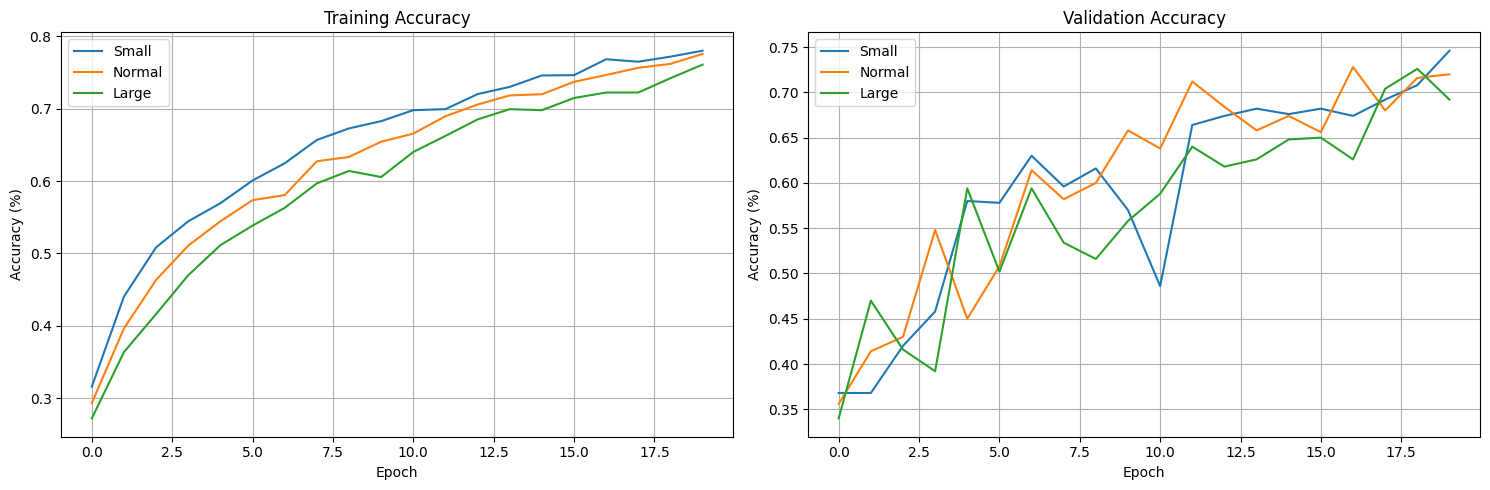

In [91]:
plot_acc([[historySmall, "Small"], [historyNormal, "Normal"], [historyLarge, "Large"]])

In [93]:
total_params_model_small = sum(p.numel() for p in model_small.parameters())
trainable_params_model_small = sum(p.numel() for p in model_small.parameters() if p.requires_grad)
print(f" Всего параметров варианта small: {total_params_model_small:,}")
print(f" Обучаемых параметров варианта small: {trainable_params_model_small:,}")
print()

total_params_model_normal = sum(p.numel() for p in model_normal.parameters())
trainable_params_model_normal = sum(p.numel() for p in model_normal.parameters() if p.requires_grad)
print(f" Всего параметров варианта normal: {total_params_model_normal:,}")
print(f" Обучаемых параметров варианта normal: {trainable_params_model_normal:,}")
print()

total_params_model_large = sum(p.numel() for p in model_large.parameters())
trainable_params_model_large = sum(p.numel() for p in model_large.parameters() if p.requires_grad)
print(f" Всего параметров варианта large: {total_params_model_large:,}")
print(f" Обучаемых параметров варианта large: {trainable_params_model_large:,}")

 Всего параметров варианта small: 1,230,538
 Обучаемых параметров варианта small: 1,230,538

 Всего параметров варианта normal: 2,799,178
 Обучаемых параметров варианта normal: 2,799,178

 Всего параметров варианта large: 4,367,818
 Обучаемых параметров варианта large: 4,367,818


In [95]:
results = [
    {"Модель": "ResNet18Small", "Количество параметров": trainable_params_model_small, "Лучшая точность валидации": best_acc_val_small, "Скорость сходимости": 20},
    {"Модель": "ResNet18Normal", "Количество параметров": trainable_params_model_normal, "Лучшая точность валидации": best_acc_val_normal, "Скорость сходимости": 16},
    {"Модель": "ResNet18Large", "Количество параметров": trainable_params_model_large, "Лучшая точность валидации": best_acc_val_large, "Скорость сходимости": 17},
]

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

| Модель         |   Количество параметров |   Лучшая точность валидации |   Скорость сходимости |
|:---------------|------------------------:|----------------------------:|----------------------:|
| ResNet18Small  |                 1230538 |                       0.746 |                    20 |
| ResNet18Normal |                 2799178 |                       0.728 |                    16 |
| ResNet18Large  |                 4367818 |                       0.726 |                    17 |


Самая маленькая модель показала лучшие результаты по точности. С увеличением глубины модели растёт переобучение. Можно сделать вывод, что самая маленькая модель с одним блоком самая оптимальная по точности, кол-ву параметров, переобучению. 

# 3.3: Эксперименты с функциями активации

In [100]:
class ResNet18ImageNetTinySmallLeaky(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.LeakyReLU(inplace=True)

        self.basic_block_11 = BasicBlock(32, 32, stride=2)

        self.basic_block_21 = BasicBlock(32, 64, stride=2)

        self.basic_block_31 = BasicBlock(64, 128, stride=2)

        self.basic_block_41 = BasicBlock(128, 256, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.basic_block_11(x)
        x = self.basic_block_21(x)
        x = self.basic_block_31(x)
        x = self.basic_block_41(x)

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x

class ResNet18ImageNetTinySmallELU(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ELU(inplace=True)

        self.basic_block_11 = BasicBlock(32, 32, stride=2)

        self.basic_block_21 = BasicBlock(32, 64, stride=2)

        self.basic_block_31 = BasicBlock(64, 128, stride=2)

        self.basic_block_41 = BasicBlock(128, 256, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.basic_block_11(x)
        x = self.basic_block_21(x)
        x = self.basic_block_31(x)
        x = self.basic_block_41(x)

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x

class ResNet18ImageNetTinySmallGELU(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.GELU()

        self.basic_block_11 = BasicBlock(32, 32, stride=2)

        self.basic_block_21 = BasicBlock(32, 64, stride=2)

        self.basic_block_31 = BasicBlock(64, 128, stride=2)

        self.basic_block_41 = BasicBlock(128, 256, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.basic_block_11(x)
        x = self.basic_block_21(x)
        x = self.basic_block_31(x)
        x = self.basic_block_41(x)

        x = self.gap(x)

        x = self.linear(torch.flatten(x, start_dim=1))
        return x

In [97]:
model_small_leaky = ResNet18ImageNetTinySmallLeaky(10)

optimizer = torch.optim.Adam(model_small_leaky.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
history_small_leaky, best_acc_val_small_leaky = train_model(
    model=model_small_leaky,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

device: cuda
Обучение на 20 эпох...
Эпоха 1/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.35it/s, loss=0.0260, acc=40.40%]


 Train Loss: 0.0290, Train Acc: 33.70%
 Val Loss: 0.0260, Val Acc: 40.40%
Сохранена лучшая модель с точностью 40.40%

Эпоха 2/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.63it/s, loss=0.0250, acc=47.20%]


 Train Loss: 0.0248, Train Acc: 44.42%
 Val Loss: 0.0250, Val Acc: 47.20%
Сохранена лучшая модель с точностью 47.20%

Эпоха 3/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.29it/s, loss=0.0221, acc=53.20%]


 Train Loss: 0.0226, Train Acc: 49.60%
 Val Loss: 0.0221, Val Acc: 53.20%
Сохранена лучшая модель с точностью 53.20%

Эпоха 4/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.33it/s, loss=0.0199, acc=59.40%]


 Train Loss: 0.0207, Train Acc: 54.90%
 Val Loss: 0.0199, Val Acc: 59.40%
Сохранена лучшая модель с точностью 59.40%

Эпоха 5/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.41it/s, loss=0.0231, acc=49.80%]


 Train Loss: 0.0194, Train Acc: 57.46%
 Val Loss: 0.0231, Val Acc: 49.80%

Эпоха 6/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.92it/s, loss=0.0200, acc=59.00%]


 Train Loss: 0.0181, Train Acc: 59.68%
 Val Loss: 0.0200, Val Acc: 59.00%

Эпоха 7/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.86it/s, loss=0.0171, acc=66.40%]


 Train Loss: 0.0171, Train Acc: 62.56%
 Val Loss: 0.0171, Val Acc: 66.40%
Сохранена лучшая модель с точностью 66.40%

Эпоха 8/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.32it/s, loss=0.0202, acc=60.40%]


 Train Loss: 0.0167, Train Acc: 64.24%
 Val Loss: 0.0202, Val Acc: 60.40%

Эпоха 9/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.45it/s, loss=0.0157, acc=67.20%]


 Train Loss: 0.0156, Train Acc: 66.16%
 Val Loss: 0.0157, Val Acc: 67.20%
Сохранена лучшая модель с точностью 67.20%

Эпоха 10/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.84it/s, loss=0.0191, acc=60.80%]


 Train Loss: 0.0152, Train Acc: 68.20%
 Val Loss: 0.0191, Val Acc: 60.80%

Эпоха 11/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.82it/s, loss=0.0163, acc=65.60%]


 Train Loss: 0.0148, Train Acc: 68.18%
 Val Loss: 0.0163, Val Acc: 65.60%

Эпоха 12/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.33it/s, loss=0.0146, acc=71.00%]


 Train Loss: 0.0139, Train Acc: 70.26%
 Val Loss: 0.0146, Val Acc: 71.00%
Сохранена лучшая модель с точностью 71.00%

Эпоха 13/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.65it/s, loss=0.0142, acc=70.40%]


 Train Loss: 0.0130, Train Acc: 72.20%
 Val Loss: 0.0142, Val Acc: 70.40%

Эпоха 14/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.76it/s, loss=0.0142, acc=67.40%]


 Train Loss: 0.0128, Train Acc: 72.88%
 Val Loss: 0.0142, Val Acc: 67.40%

Эпоха 15/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.99it/s, loss=0.0145, acc=69.40%]


 Train Loss: 0.0120, Train Acc: 74.12%
 Val Loss: 0.0145, Val Acc: 69.40%

Эпоха 16/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.84it/s, loss=0.0161, acc=66.00%]


 Train Loss: 0.0117, Train Acc: 75.34%
 Val Loss: 0.0161, Val Acc: 66.00%

Эпоха 17/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.65it/s, loss=0.0158, acc=68.00%]


 Train Loss: 0.0116, Train Acc: 75.52%
 Val Loss: 0.0158, Val Acc: 68.00%

Эпоха 18/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.33it/s, loss=0.0197, acc=62.40%]


 Train Loss: 0.0111, Train Acc: 75.98%
 Val Loss: 0.0197, Val Acc: 62.40%

Эпоха 19/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.80it/s, loss=0.0149, acc=68.00%]


 Train Loss: 0.0108, Train Acc: 77.18%
 Val Loss: 0.0149, Val Acc: 68.00%

Эпоха 20/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.70it/s, loss=0.0122, acc=71.80%]

 Train Loss: 0.0101, Train Acc: 78.74%
 Val Loss: 0.0122, Val Acc: 71.80%
Сохранена лучшая модель с точностью 71.80%



In [98]:
model_small_ELU = ResNet18ImageNetTinySmallELU(10)

optimizer = torch.optim.Adam(model_small_ELU.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
history_small_ELU, best_acc_val_small_ELU = train_model(
    model=model_small_ELU,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

device: cuda
Обучение на 20 эпох...
Эпоха 1/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.16it/s, loss=0.0324, acc=34.00%]


 Train Loss: 0.0298, Train Acc: 31.14%
 Val Loss: 0.0324, Val Acc: 34.00%
Сохранена лучшая модель с точностью 34.00%

Эпоха 2/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.29it/s, loss=0.0237, acc=50.40%]


 Train Loss: 0.0251, Train Acc: 44.22%
 Val Loss: 0.0237, Val Acc: 50.40%
Сохранена лучшая модель с точностью 50.40%

Эпоха 3/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.22it/s, loss=0.0283, acc=43.40%]


 Train Loss: 0.0222, Train Acc: 50.90%
 Val Loss: 0.0283, Val Acc: 43.40%

Эпоха 4/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.09it/s, loss=0.0237, acc=52.00%]


 Train Loss: 0.0202, Train Acc: 55.30%
 Val Loss: 0.0237, Val Acc: 52.00%
Сохранена лучшая модель с точностью 52.00%

Эпоха 5/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s, loss=0.0193, acc=58.40%]


 Train Loss: 0.0188, Train Acc: 59.02%
 Val Loss: 0.0193, Val Acc: 58.40%
Сохранена лучшая модель с точностью 58.40%

Эпоха 6/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 11.12it/s, loss=0.0188, acc=56.00%]


 Train Loss: 0.0180, Train Acc: 61.26%
 Val Loss: 0.0188, Val Acc: 56.00%

Эпоха 7/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.93it/s, loss=0.0201, acc=61.60%]


 Train Loss: 0.0168, Train Acc: 63.80%
 Val Loss: 0.0201, Val Acc: 61.60%
Сохранена лучшая модель с точностью 61.60%

Эпоха 8/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.88it/s, loss=0.0204, acc=59.60%]


 Train Loss: 0.0158, Train Acc: 66.30%
 Val Loss: 0.0204, Val Acc: 59.60%

Эпоха 9/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.09it/s, loss=0.0148, acc=67.60%]


 Train Loss: 0.0156, Train Acc: 66.54%
 Val Loss: 0.0148, Val Acc: 67.60%
Сохранена лучшая модель с точностью 67.60%

Эпоха 10/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.16it/s, loss=0.0166, acc=65.20%]


 Train Loss: 0.0144, Train Acc: 69.72%
 Val Loss: 0.0166, Val Acc: 65.20%

Эпоха 11/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.0165, acc=65.20%]


 Train Loss: 0.0139, Train Acc: 70.44%
 Val Loss: 0.0165, Val Acc: 65.20%

Эпоха 12/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.28it/s, loss=0.0147, acc=70.80%]


 Train Loss: 0.0133, Train Acc: 71.80%
 Val Loss: 0.0147, Val Acc: 70.80%
Сохранена лучшая модель с точностью 70.80%

Эпоха 13/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.99it/s, loss=0.0163, acc=68.80%]


 Train Loss: 0.0127, Train Acc: 73.10%
 Val Loss: 0.0163, Val Acc: 68.80%

Эпоха 14/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 19.51it/s, loss=0.0187, acc=63.60%]


 Train Loss: 0.0119, Train Acc: 74.54%
 Val Loss: 0.0187, Val Acc: 63.60%

Эпоха 15/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.90it/s, loss=0.0135, acc=73.40%]


 Train Loss: 0.0117, Train Acc: 75.08%
 Val Loss: 0.0135, Val Acc: 73.40%
Сохранена лучшая модель с точностью 73.40%

Эпоха 16/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.17it/s, loss=0.0150, acc=71.20%]


 Train Loss: 0.0112, Train Acc: 76.26%
 Val Loss: 0.0150, Val Acc: 71.20%

Эпоха 17/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.56it/s, loss=0.0127, acc=72.60%]


 Train Loss: 0.0113, Train Acc: 76.20%
 Val Loss: 0.0127, Val Acc: 72.60%

Эпоха 18/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.67it/s, loss=0.0143, acc=70.00%]


 Train Loss: 0.0109, Train Acc: 76.86%
 Val Loss: 0.0143, Val Acc: 70.00%

Эпоха 19/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.00it/s, loss=0.0127, acc=77.20%]


 Train Loss: 0.0102, Train Acc: 77.74%
 Val Loss: 0.0127, Val Acc: 77.20%
Сохранена лучшая модель с точностью 77.20%

Эпоха 20/20


Validation: 100%|██████████| 8/8 [00:01<00:00,  7.84it/s, loss=0.0168, acc=70.80%]

 Train Loss: 0.0096, Train Acc: 79.32%
 Val Loss: 0.0168, Val Acc: 70.80%



In [101]:
model_small_GELU = ResNet18ImageNetTinySmallGELU(10)

optimizer = torch.optim.Adam(model_small_GELU.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
history_small_GELU, best_acc_val_small_GELU = train_model(
    model=model_small_GELU,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

device: cuda
Обучение на 20 эпох...
Эпоха 1/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.68it/s, loss=0.0274, acc=39.20%]


 Train Loss: 0.0298, Train Acc: 32.04%
 Val Loss: 0.0274, Val Acc: 39.20%
Сохранена лучшая модель с точностью 39.20%

Эпоха 2/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.58it/s, loss=0.0232, acc=48.40%]


 Train Loss: 0.0250, Train Acc: 43.60%
 Val Loss: 0.0232, Val Acc: 48.40%
Сохранена лучшая модель с точностью 48.40%

Эпоха 3/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.22it/s, loss=0.0258, acc=45.00%]


 Train Loss: 0.0228, Train Acc: 49.42%
 Val Loss: 0.0258, Val Acc: 45.00%

Эпоха 4/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.16it/s, loss=0.0216, acc=58.00%]


 Train Loss: 0.0207, Train Acc: 54.88%
 Val Loss: 0.0216, Val Acc: 58.00%
Сохранена лучшая модель с точностью 58.00%

Эпоха 5/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.85it/s, loss=0.0202, acc=57.40%]


 Train Loss: 0.0194, Train Acc: 58.10%
 Val Loss: 0.0202, Val Acc: 57.40%

Эпоха 6/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s, loss=0.0190, acc=58.00%]


 Train Loss: 0.0180, Train Acc: 60.74%
 Val Loss: 0.0190, Val Acc: 58.00%

Эпоха 7/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  9.22it/s, loss=0.0173, acc=66.20%]


 Train Loss: 0.0171, Train Acc: 63.68%
 Val Loss: 0.0173, Val Acc: 66.20%
Сохранена лучшая модель с точностью 66.20%

Эпоха 8/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.71it/s, loss=0.0217, acc=55.20%]


 Train Loss: 0.0161, Train Acc: 65.62%
 Val Loss: 0.0217, Val Acc: 55.20%

Эпоха 9/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s, loss=0.0175, acc=65.40%]


 Train Loss: 0.0159, Train Acc: 66.00%
 Val Loss: 0.0175, Val Acc: 65.40%

Эпоха 10/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.37it/s, loss=0.0164, acc=64.80%]


 Train Loss: 0.0148, Train Acc: 68.64%
 Val Loss: 0.0164, Val Acc: 64.80%

Эпоха 11/20


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.62it/s, loss=0.0168, acc=63.40%]


 Train Loss: 0.0141, Train Acc: 69.16%
 Val Loss: 0.0168, Val Acc: 63.40%

Эпоха 12/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.39it/s, loss=0.0166, acc=65.20%]


 Train Loss: 0.0133, Train Acc: 71.44%
 Val Loss: 0.0166, Val Acc: 65.20%

Эпоха 13/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.77it/s, loss=0.0171, acc=66.20%]


 Train Loss: 0.0131, Train Acc: 72.10%
 Val Loss: 0.0171, Val Acc: 66.20%

Эпоха 14/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.13it/s, loss=0.0146, acc=70.40%]


 Train Loss: 0.0121, Train Acc: 73.46%
 Val Loss: 0.0146, Val Acc: 70.40%
Сохранена лучшая модель с точностью 70.40%

Эпоха 15/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.77it/s, loss=0.0163, acc=66.00%]


 Train Loss: 0.0122, Train Acc: 74.50%
 Val Loss: 0.0163, Val Acc: 66.00%

Эпоха 16/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.54it/s, loss=0.0149, acc=70.40%]


 Train Loss: 0.0113, Train Acc: 76.28%
 Val Loss: 0.0149, Val Acc: 70.40%

Эпоха 17/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.04it/s, loss=0.0144, acc=71.20%]


 Train Loss: 0.0115, Train Acc: 75.24%
 Val Loss: 0.0144, Val Acc: 71.20%
Сохранена лучшая модель с точностью 71.20%

Эпоха 18/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s, loss=0.0163, acc=67.00%]


 Train Loss: 0.0107, Train Acc: 77.04%
 Val Loss: 0.0163, Val Acc: 67.00%

Эпоха 19/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 12.24it/s, loss=0.0135, acc=74.00%]


 Train Loss: 0.0101, Train Acc: 78.44%
 Val Loss: 0.0135, Val Acc: 74.00%
Сохранена лучшая модель с точностью 74.00%

Эпоха 20/20


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.53it/s, loss=0.0138, acc=71.80%]

 Train Loss: 0.0098, Train Acc: 78.62%
 Val Loss: 0.0138, Val Acc: 71.80%



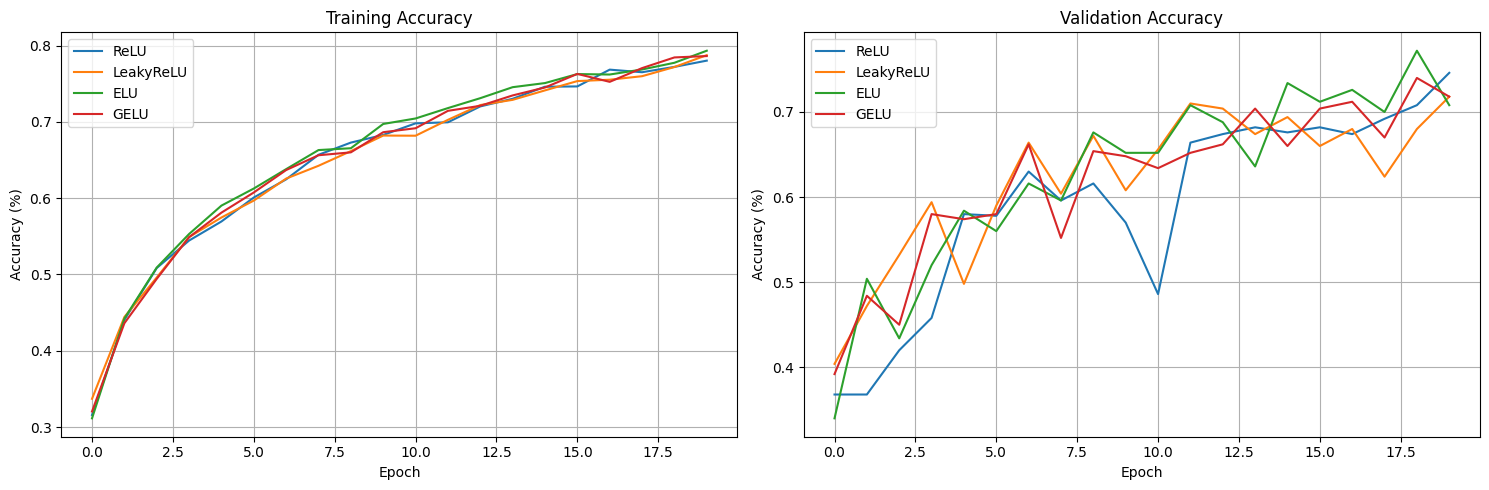

In [103]:
plot_acc([[historySmall, "ReLU"], [history_small_leaky, "LeakyReLU"], [history_small_ELU, "ELU"], [history_small_GELU, "GELU"]])

In [106]:
results = [
    {"Модель": "ResNet18SmallReLU", "Лучшая точность валидации": best_acc_val_small, "Скорость сходимости": 20},
    {"Модель": "ResNet18SmallLeaky", "Лучшая точность валидации": best_acc_val_small_leaky, "Скорость сходимости": 20},
    {"Модель": "ResNet18SmallELU", "Лучшая точность валидации": best_acc_val_small_ELU, "Скорость сходимости": 17},
    {"Модель": "ResNet18SmallGELU", "Лучшая точность валидации": best_acc_val_small_GELU, "Скорость сходимости": 17},
]

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

| Модель             |   Лучшая точность валидации |   Скорость сходимости |
|:-------------------|----------------------------:|----------------------:|
| ResNet18SmallReLU  |                       0.746 |                    20 |
| ResNet18SmallLeaky |                       0.718 |                    20 |
| ResNet18SmallELU   |                       0.772 |                    17 |
| ResNet18SmallGELU  |                       0.74  |                    17 |


По скорости сходимости ELU и GELU лучше остальных. Самая высока точность у ELU, поэтому в фильнальной версии будет использоваться эта активация.

# Часть 4: Финальная модель и тестирование

In [107]:
model_final = ResNet18ImageNetTinySmallELU(10)

optimizer = torch.optim.AdamW(model_final.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
history_final, best_acc_val_final = train_model(
    model=model_final,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=40
)

device: cuda
Обучение на 40 эпох...
Эпоха 1/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.11it/s, loss=0.0271, acc=40.00%]


 Train Loss: 0.0299, Train Acc: 31.92%
 Val Loss: 0.0271, Val Acc: 40.00%
Сохранена лучшая модель с точностью 40.00%

Эпоха 2/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.17it/s, loss=0.0282, acc=41.60%]


 Train Loss: 0.0254, Train Acc: 42.14%
 Val Loss: 0.0282, Val Acc: 41.60%
Сохранена лучшая модель с точностью 41.60%

Эпоха 3/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.46it/s, loss=0.0195, acc=58.00%]


 Train Loss: 0.0229, Train Acc: 48.66%
 Val Loss: 0.0195, Val Acc: 58.00%
Сохранена лучшая модель с точностью 58.00%

Эпоха 4/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s, loss=0.0209, acc=54.20%]


 Train Loss: 0.0205, Train Acc: 54.96%
 Val Loss: 0.0209, Val Acc: 54.20%

Эпоха 5/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.27it/s, loss=0.0225, acc=53.00%]


 Train Loss: 0.0196, Train Acc: 58.82%
 Val Loss: 0.0225, Val Acc: 53.00%

Эпоха 6/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.29it/s, loss=0.0205, acc=56.00%]


 Train Loss: 0.0183, Train Acc: 60.28%
 Val Loss: 0.0205, Val Acc: 56.00%

Эпоха 7/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.0215, acc=54.80%]


 Train Loss: 0.0171, Train Acc: 62.72%
 Val Loss: 0.0215, Val Acc: 54.80%

Эпоха 8/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.84it/s, loss=0.0180, acc=63.80%]


 Train Loss: 0.0168, Train Acc: 64.10%
 Val Loss: 0.0180, Val Acc: 63.80%
Сохранена лучшая модель с точностью 63.80%

Эпоха 9/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 13.47it/s, loss=0.0163, acc=64.40%]


 Train Loss: 0.0158, Train Acc: 66.88%
 Val Loss: 0.0163, Val Acc: 64.40%
Сохранена лучшая модель с точностью 64.40%

Эпоха 10/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.06it/s, loss=0.0221, acc=57.40%]


 Train Loss: 0.0153, Train Acc: 67.68%
 Val Loss: 0.0221, Val Acc: 57.40%

Эпоха 11/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.87it/s, loss=0.0190, acc=58.80%]


 Train Loss: 0.0147, Train Acc: 68.68%
 Val Loss: 0.0190, Val Acc: 58.80%

Эпоха 12/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.18it/s, loss=0.0163, acc=67.80%]


 Train Loss: 0.0142, Train Acc: 69.88%
 Val Loss: 0.0163, Val Acc: 67.80%
Сохранена лучшая модель с точностью 67.80%

Эпоха 13/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.84it/s, loss=0.0165, acc=66.80%]


 Train Loss: 0.0132, Train Acc: 72.26%
 Val Loss: 0.0165, Val Acc: 66.80%

Эпоха 14/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.78it/s, loss=0.0142, acc=70.20%]


 Train Loss: 0.0128, Train Acc: 72.32%
 Val Loss: 0.0142, Val Acc: 70.20%
Сохранена лучшая модель с точностью 70.20%

Эпоха 15/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 20.26it/s, loss=0.0156, acc=67.40%]


 Train Loss: 0.0122, Train Acc: 74.26%
 Val Loss: 0.0156, Val Acc: 67.40%

Эпоха 16/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.0130, acc=73.20%]


 Train Loss: 0.0119, Train Acc: 74.10%
 Val Loss: 0.0130, Val Acc: 73.20%
Сохранена лучшая модель с точностью 73.20%

Эпоха 17/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.0143, acc=70.00%]


 Train Loss: 0.0112, Train Acc: 76.10%
 Val Loss: 0.0143, Val Acc: 70.00%

Эпоха 18/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.0144, acc=71.60%]


 Train Loss: 0.0108, Train Acc: 76.60%
 Val Loss: 0.0144, Val Acc: 71.60%

Эпоха 19/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 10.22it/s, loss=0.0150, acc=69.00%]


 Train Loss: 0.0106, Train Acc: 77.50%
 Val Loss: 0.0150, Val Acc: 69.00%

Эпоха 20/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.44it/s, loss=0.0129, acc=71.80%]


 Train Loss: 0.0102, Train Acc: 78.08%
 Val Loss: 0.0129, Val Acc: 71.80%

Эпоха 21/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.20it/s, loss=0.0145, acc=70.20%]


 Train Loss: 0.0097, Train Acc: 79.10%
 Val Loss: 0.0145, Val Acc: 70.20%

Эпоха 22/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.52it/s, loss=0.0134, acc=72.80%]


 Train Loss: 0.0093, Train Acc: 79.88%
 Val Loss: 0.0134, Val Acc: 72.80%

Эпоха 23/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s, loss=0.0134, acc=74.20%]


 Train Loss: 0.0096, Train Acc: 79.04%
 Val Loss: 0.0134, Val Acc: 74.20%
Сохранена лучшая модель с точностью 74.20%

Эпоха 24/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.67it/s, loss=0.0133, acc=74.80%]


 Train Loss: 0.0087, Train Acc: 81.32%
 Val Loss: 0.0133, Val Acc: 74.80%
Сохранена лучшая модель с точностью 74.80%

Эпоха 25/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.74it/s, loss=0.0134, acc=74.40%]


 Train Loss: 0.0087, Train Acc: 81.10%
 Val Loss: 0.0134, Val Acc: 74.40%

Эпоха 26/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.06it/s, loss=0.0147, acc=71.20%]


 Train Loss: 0.0082, Train Acc: 82.98%
 Val Loss: 0.0147, Val Acc: 71.20%

Эпоха 27/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.83it/s, loss=0.0134, acc=74.80%]


 Train Loss: 0.0076, Train Acc: 83.60%
 Val Loss: 0.0134, Val Acc: 74.80%

Эпоха 28/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.86it/s, loss=0.0129, acc=74.80%]


 Train Loss: 0.0079, Train Acc: 82.82%
 Val Loss: 0.0129, Val Acc: 74.80%

Эпоха 29/40


Validation: 100%|██████████| 8/8 [00:00<00:00,  8.11it/s, loss=0.0161, acc=70.40%]


 Train Loss: 0.0078, Train Acc: 82.80%
 Val Loss: 0.0161, Val Acc: 70.40%

Эпоха 30/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.17it/s, loss=0.0127, acc=73.60%]


 Train Loss: 0.0067, Train Acc: 85.68%
 Val Loss: 0.0127, Val Acc: 73.60%

Эпоха 31/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s, loss=0.0148, acc=72.80%]


 Train Loss: 0.0077, Train Acc: 83.96%
 Val Loss: 0.0148, Val Acc: 72.80%

Эпоха 32/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.11it/s, loss=0.0123, acc=77.80%]


 Train Loss: 0.0066, Train Acc: 85.64%
 Val Loss: 0.0123, Val Acc: 77.80%
Сохранена лучшая модель с точностью 77.80%

Эпоха 33/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 17.48it/s, loss=0.0118, acc=76.80%]


 Train Loss: 0.0062, Train Acc: 86.32%
 Val Loss: 0.0118, Val Acc: 76.80%

Эпоха 34/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s, loss=0.0131, acc=74.20%]


 Train Loss: 0.0061, Train Acc: 87.00%
 Val Loss: 0.0131, Val Acc: 74.20%

Эпоха 35/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 15.10it/s, loss=0.0141, acc=73.00%]


 Train Loss: 0.0061, Train Acc: 86.36%
 Val Loss: 0.0141, Val Acc: 73.00%

Эпоха 36/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 14.41it/s, loss=0.0140, acc=73.60%]


 Train Loss: 0.0056, Train Acc: 87.72%
 Val Loss: 0.0140, Val Acc: 73.60%

Эпоха 37/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.96it/s, loss=0.0117, acc=77.60%]


 Train Loss: 0.0055, Train Acc: 87.98%
 Val Loss: 0.0117, Val Acc: 77.60%

Эпоха 38/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.0157, acc=72.60%]


 Train Loss: 0.0050, Train Acc: 89.52%
 Val Loss: 0.0157, Val Acc: 72.60%

Эпоха 39/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.34it/s, loss=0.0134, acc=75.80%]


 Train Loss: 0.0056, Train Acc: 88.74%
 Val Loss: 0.0134, Val Acc: 75.80%

Эпоха 40/40


Validation: 100%|██████████| 8/8 [00:00<00:00, 16.07it/s, loss=0.0113, acc=77.20%]

 Train Loss: 0.0055, Train Acc: 87.84%
 Val Loss: 0.0113, Val Acc: 77.20%



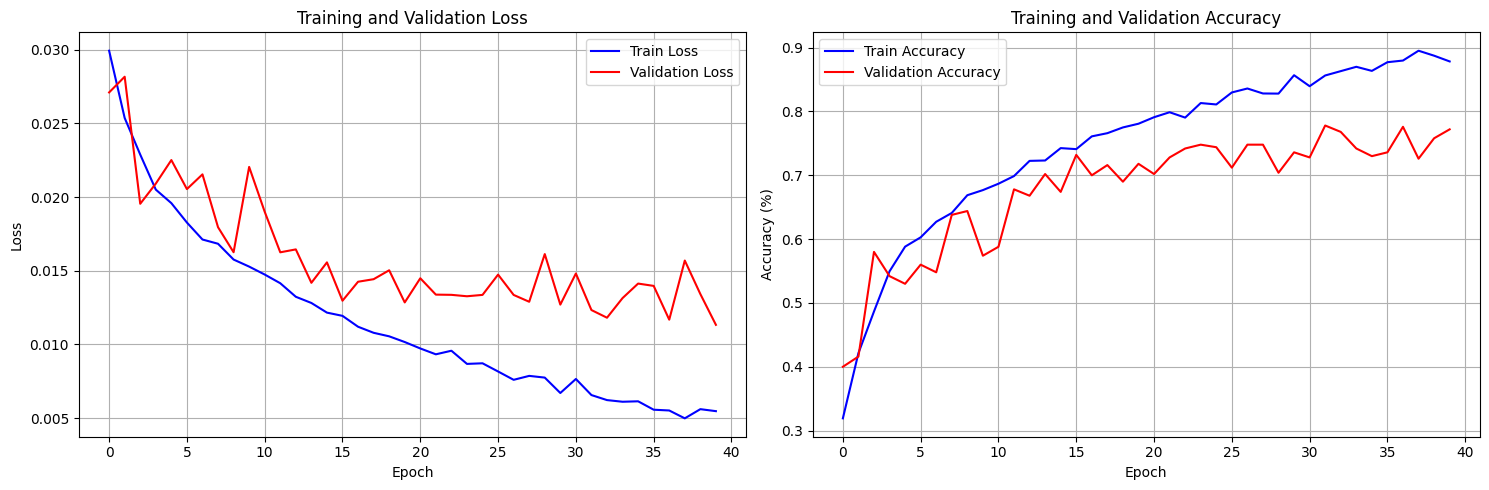

In [108]:
plot_training_history(history_final)

In [ ]:
def test(model, test_loader, classes, device):
    model.to(device)
    model.eval()

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            all_targets.append(target.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())

    targets = np.concatenate(all_targets)
    predictions = np.concatenate(all_predictions)

    acc = accuracy_score(targets, predictions)
    cm = confusion_matrix(targets, predictions)
    
    report_str = classification_report(
        targets, predictions,
        target_names=classes,
        digits=4,
        zero_division=0
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classes,
        yticklabels=classes,
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f'Confusion Matrix (Accuracy: {acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Test Accuracy: {100 * acc:.2f}%\n")
    print("📊 Classification Report:")
    print(report_str)

    return {
        'accuracy': acc,
        'report': report_str,
        'confusion_matrix': cm,
        'predictions': predictions,
        'targets': targets
    }

def load_tiny_imagenet_labels(words_path="/home/victor/Desktop/itmo/dz_2/tiny-imagenet-200/tiny-imagenet-200/words.txt"):
    labels = {}
    with open(words_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                wnid = parts[0]
                desc = parts[1]
                labels[wnid] = desc
    return labels



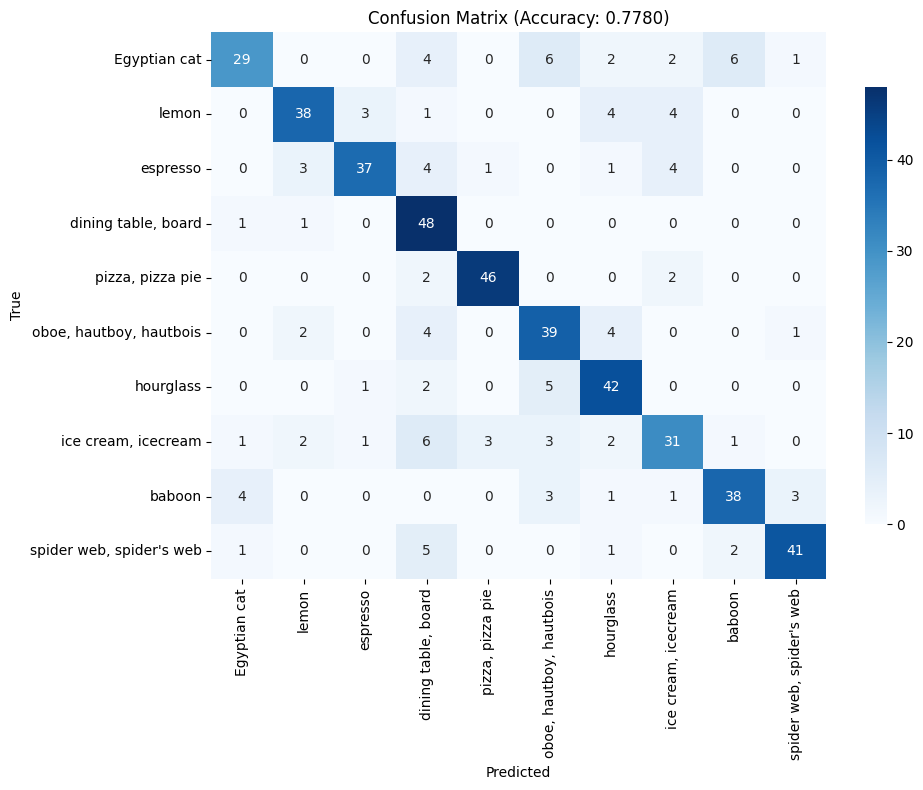


✅ Test Accuracy: 77.80%

📊 Classification Report:
                          precision    recall  f1-score   support

            Egyptian cat     0.8056    0.5800    0.6744        50
                   lemon     0.8261    0.7600    0.7917        50
                espresso     0.8810    0.7400    0.8043        50
     dining table, board     0.6316    0.9600    0.7619        50
        pizza, pizza pie     0.9200    0.9200    0.9200        50
 oboe, hautboy, hautbois     0.6964    0.7800    0.7358        50
               hourglass     0.7368    0.8400    0.7850        50
     ice cream, icecream     0.7045    0.6200    0.6596        50
                  baboon     0.8085    0.7600    0.7835        50
spider web, spider's web     0.8913    0.8200    0.8542        50

                accuracy                         0.7780       500
               macro avg     0.7902    0.7780    0.7770       500
            weighted avg     0.7902    0.7780    0.7770       500



In [ ]:
model_final_test = ResNet18ImageNetTinySmallELU(10)

checkpoint = torch.load('/home/victor/Desktop/itmo/dz_2/tiny-imagenet-200/best_model.pth', map_location=device)
model_final_test.load_state_dict(checkpoint)

calsses_names = load_tiny_imagenet_labels()
calsses = [calsses_names[val_dataset.class_names[i]] for i in selected_classes] 

results = test(model_final_test, val_loader, calsses, device)

In [ ]:
def visualize_predictions(model, test_dataset, device, class_names=None, n_samples=10, seed=42):
    """
    Визуализирует n_samples случайных примеров из test_dataset с истинными и предсказанными классами.
    
    Args:
        model: обученная модель
        test_dataset: Dataset (например, val_subset_dataset)
        device: 'cpu' или 'cuda'
        class_names: список имён классов (длиной = num_classes), например: ['goldfish', 'tabby', ...]
        n_samples: сколько примеров показать
        seed: для воспроизводимости
    """
    model.eval()
    
    rng = np.random.default_rng(seed)
    indices = rng.choice(len(test_dataset), size=n_samples, replace=False)
    
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img_tensor, true_label = test_dataset[idx] 
            img_tensor = img_tensor.unsqueeze(0).to(device)  # [1, C, H, W]
            
            output = model(img_tensor)
            _, pred_label = output.max(1)
            pred_label = pred_label.item()
            true_label = true_label.item() if isinstance(true_label, torch.Tensor) else true_label
            
            img_vis = inv_normalize(img_tensor.squeeze(0).cpu())
            img_vis = torch.clamp(img_vis, 0, 1)  # значения в [0,1]
            img_np = img_vis.permute(1, 2, 0).numpy()
            
            true_name = class_names[true_label] if class_names else f"Class {true_label}"
            pred_name = class_names[pred_label] if class_names else f"Class {pred_label}"
            color = "green" if true_label == pred_label else "red"
            
            axes[i].imshow(img_np)
            axes[i].set_title(f"True: {true_name}\nPred: {pred_name}", 
                              color=color, fontsize=10)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Test Set Predictions (Green = Correct, Red = Wrong)", y=1.02, fontsize=14)
    plt.show()

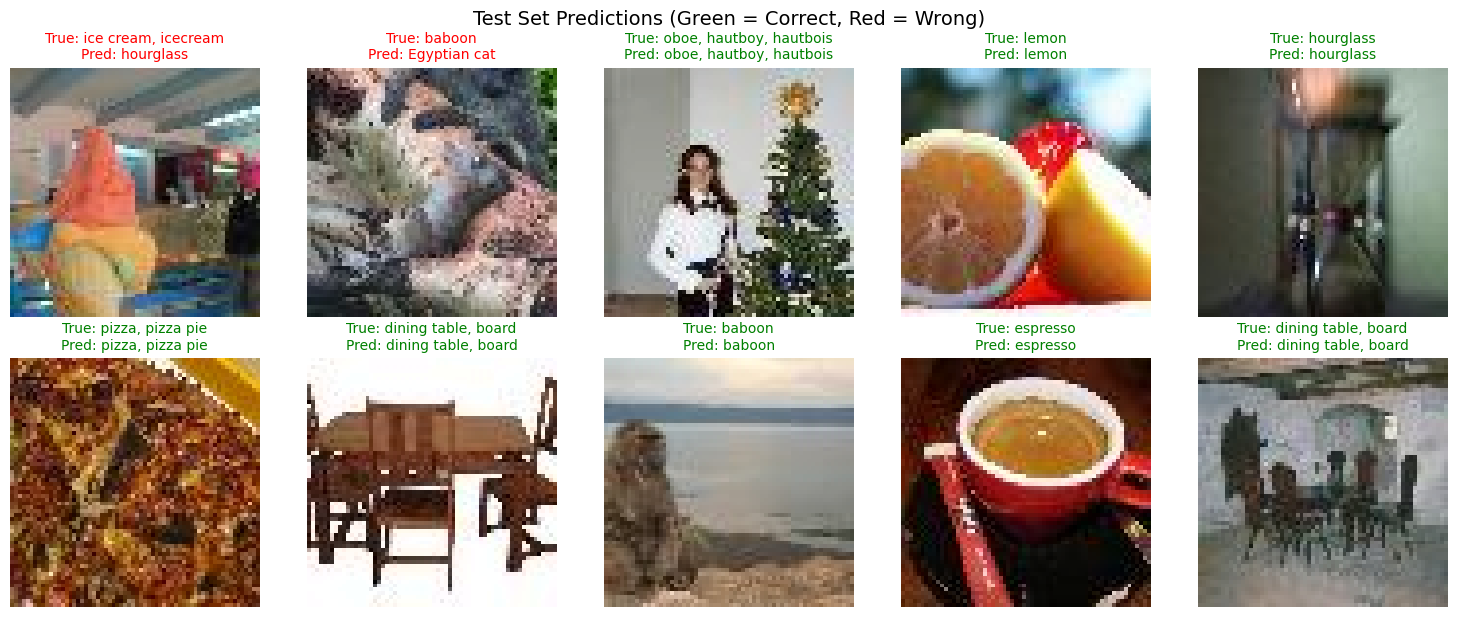

In [147]:
visualize_predictions(model_final, val_subset_dataset, device, class_names=calsses)

In [ ]:
results = [
    {"Этап": "Baseline", "Конфигурация": "Базовая модель", "Параметры": trainable_params, "Val Accuracy": best_acc_val, "Train Accuracy": 0.71},
    {"Этап": "3.1-A", "Конфигурация": "32→64→128→256", "Параметры": trainable_params_A, "Val Accuracy":  best_acc_val_A, "Train Accuracy": 0.76},
    {"Этап": "3.1-B", "Конфигурация": "64→128→256", "Параметры": trainable_params_B, "Val Accuracy": best_acc_val, "Train Accuracy": 0.71},
    {"Этап": "3.2-A", "Конфигурация": "[1,1,1,1] блоков", "Параметры": trainable_params_model_small, "Val Accuracy": best_acc_val_small, "Train Accuracy": 0.76},
    {"Этап": "3.2-B", "Конфигурация": "[2,2,2,2] блоков", "Параметры": trainable_params_model_normal, "Val Accuracy": best_acc_val_normal, "Train Accuracy": 0.77},
    {"Этап": "3.2-C", "Конфигурация": "[3,3,3,3] блоков", "Параметры": trainable_params_model_large, "Val Accuracy": best_acc_val_large, "Train Accuracy": 0.76},
    {"Этап": "3.3-A", "Конфигурация": "ReLU", "Параметры": trainable_params_model_small, "Val Accuracy": best_acc_val_small, "Train Accuracy": 0.76},
    {"Этап": "3.3-B", "Конфигурация": "LeakyReLU", "Параметры": trainable_params_model_small, "Val Accuracy": best_acc_val_small_leaky, "Train Accuracy": 0.78},
    {"Этап": "3.3-C", "Конфигурация": "ELU", "Параметры": trainable_params_model_small, "Val Accuracy": best_acc_val_small_ELU, "Train Accuracy": 0.77},
    {"Этап": "3.3-D", "Конфигурация": "GELU ", "Параметры": trainable_params_model_small, "Val Accuracy": best_acc_val_small_GELU, "Train Accuracy": 0.78},
    {"Этап": "Final", "Конфигурация": "Лучшая конфигурация", "Параметры": trainable_params_model_small, "Val Accuracy": best_acc_val_final, "Train Accuracy": 0.9},
]

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

| Этап     | Конфигурация        |   Параметры |   Val Accuracy |   Train Accuracy |
|:---------|:--------------------|------------:|---------------:|-----------------:|
| Baseline | Базовая модель      |     2778058 |          0.68  |             0.71 |
| 3.1-A    | 32→64→128→256       |     2799178 |          0.698 |             0.76 |
| 3.1-B    | 64→128→256          |     2778058 |          0.68  |             0.71 |
| 3.2-A    | [1,1,1,1] блоков    |     1230538 |          0.746 |             0.76 |
| 3.2-B    | [2,2,2,2] блоков    |     2799178 |          0.728 |             0.77 |
| 3.2-C    | [3,3,3,3] блоков    |     4367818 |          0.726 |             0.76 |
| 3.3-A    | ReLU                |     1230538 |          0.746 |             0.76 |
| 3.3-B    | LeakyReLU           |     1230538 |          0.718 |             0.78 |
| 3.3-C    | ELU                 |     1230538 |          0.772 |             0.77 |
| 3.3-D    | GELU                |     1230538 |          0.74  |